In [10]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [11]:
#ONLY FOR COLLAB RUNTIME
%load_ext tensorboard
%tensorflow_version 1.x

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [12]:
#ONLY FOR COLLAB RUNTIME
!pip install stable-baselines[mpi]==2.10.1 --quiet
!pip install pyvirtualdisplay
!pip install procgen --quiet
!pip install gym --quiet
!pip install gym3 --quiet
!pip install tensorflow-gpu==1.15.2 --quiet

In [13]:
import sys
sys.path.append('/content/gdrive/MyDrive/CSW182 Final')
#sys.path.append('/content/gdrive/Sharedwithme/CSW182 Final')

In [14]:
import imageio
import time
import numpy as np
import base64
import IPython
import PIL.Image
import pyvirtualdisplay
import pickle

# Video 
from pathlib import Path
from IPython import display as ipythondisplay

# Stable baselines

from helpers import record
from MIXREG_ImpalaCnn import ImpalaCnn

from mixreg import MIXREG
from stable_baselines.common.evaluation import evaluate_policy
from gym3 import ToGymEnv, ViewerWrapper, ExtractDictObWrapper
from stable_baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from procgen import ProcgenGym3Env

In [15]:
#logs_base_dir = './runs' # Log DIR
env_id = 'fruitbot'
env = ProcgenGym3Env(num=1, env_name=env_id, distribution_mode='easy', num_levels=100)
states = pickle.load(open('/content/gdrive/MyDrive/CSW182 Final/100FruitBot/100env.pickle', 'rb'))
env.callmethod("set_state", states)
env = ExtractDictObWrapper(env, key="rgb")
env = ToGymEnv(env)
env = DummyVecEnv([lambda:env])

In [16]:
model = MIXREG.load('/content/gdrive/MyDrive/CSW182 Final/100FruitBot/100mixreg_impala.checkpoint', env=env, policy=ImpalaCnn)

In [17]:
import matplotlib.pyplot as plt

def run_training(model, steps_per_round=100000,limit=20):
# This function will run a training with value set in `steps_per_round`
# after each round it will measure it's value, If value is under `limit` it will keep training until score limit is reached.  
  score = 0
  best_score = -10000
  score_array = pickle.load(open('/content/gdrive/MyDrive/CSW182 Final/100FruitBot/reg100score_array.pickle', 'rb'))
  timestep_array = pickle.load(open( '/content/gdrive/MyDrive/CSW182 Final/100FruitBot/reg100timestep_array.pickle', 'rb'))
  steps_total = timestep_array[len(timestep_array) - 1]

  while score < limit:
      steps_total = steps_total + steps_per_round
      model.learn(total_timesteps=steps_per_round)

      new_evaluation = evaluate_policy(model, env, n_eval_episodes=100, deterministic=True, render=False, callback=None, reward_threshold=None, return_episode_rewards=False)
      score = new_evaluation[0]
      timestep_array.append(steps_total)
      score_array.append(score)
      pickle.dump(score_array, open('/content/gdrive/MyDrive/CSW182 Final/100FruitBot/reg100score_array.pickle', 'wb'))
      pickle.dump(timestep_array, open( '/content/gdrive/MyDrive/CSW182 Final/100FruitBot/reg100timestep_array.pickle', 'wb'))
      model.save('/content/gdrive/MyDrive/CSW182 Final/100FruitBot/100mixreg_impala.checkpoint')

      if score > best_score:
        best_score = score
        model.save('/content/gdrive/MyDrive/CSW182 Final/100FruitBot/100mixreg_impala.best')
        #record(model, length=1000) # uncomment to show video from each round
      print('steps_total: ' + str(steps_total))
      print("Mean reward:", score )
    

  # Threshold reached > evaluate over 100 episodes > Video rec/display
  print("Reward limit achived, measuring over 100ep & recording video, please wait...")
  record(model, length=1000)
  ep100 = evaluate_policy(model, env, n_eval_episodes=100, deterministic=True, render=False, callback=None, reward_threshold=None, return_episode_rewards=False)
  print("Mean Reward 100 Episodes: ", ep100[0])
  plt.plot(timestep_array, score_array)
  plt.xlabel('Total Timesteps')
  plt.ylabel('Mean reward over 100 different levels')

steps_total: 1700000
Mean reward: 12.8
steps_total: 1800000
Mean reward: 11.06
steps_total: 1900000
Mean reward: 12.99
steps_total: 2000000
Mean reward: 14.93
steps_total: 2100000
Mean reward: 16.51
steps_total: 2200000
Mean reward: 13.0
steps_total: 2300000
Mean reward: 14.58
steps_total: 2400000
Mean reward: 13.32
steps_total: 2500000
Mean reward: 10.21
steps_total: 2600000
Mean reward: 13.17
steps_total: 2700000
Mean reward: 17.64
steps_total: 2800000
Mean reward: 14.14
steps_total: 2900000
Mean reward: 17.07
steps_total: 3000000
Mean reward: 15.79
steps_total: 3100000
Mean reward: 15.41
steps_total: 3200000
Mean reward: 16.05
steps_total: 3300000
Mean reward: 20.13
Reward limit achived, measuring over 100ep & recording video, please wait...


Mean Reward 100 Episodes:  18.83


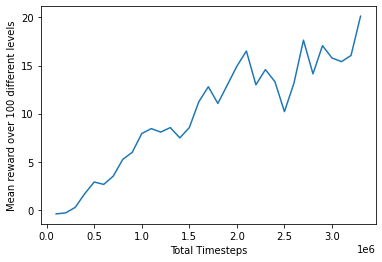

In [18]:
run_training(model)